In [2]:
import pyathena as pa
import numpy as np
import matplotlib.pyplot as plt
from for_hii import hii
from pathlib import Path
import yt
import sys
sys.path.insert(0,'/home/cjlee/practice/athena/vis/python')
import athena_read
from astropy.io import ascii
import matplotlib as mpl
from astropy import units as au
from astropy.table import QTable
from astropy import constants as const
from add_fields_hii import add_fields
import yt.units as yu
from mpl_toolkits.axes_grid1 import AxesGrid
from pyathena.io.timing_reader import TimingReader
import pickle
mpl.rcParams['font.size'] = 16
#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['xtick.top'] = True
#mpl.rcParams['ytick.right'] = True
yt.set_log_level(50)

In [3]:
path_='/data/cjlee/hii/various_nH0_Qi'
datapath=Path(path_)
pathlist=list(datapath.glob('*hii*'))
path=pathlist[24]
path

PosixPath('/data/cjlee/hii/various_nH0_Qi/hii_Q49.0n2.0_nx_256_fdt_0.50_test3')

### 1) Mass

### $\dot{m}_{box}+\dot{m}_{out}=0$
### $\dot{m}_{ion,box}+\dot{m}_{ion,out}=\dot{m}_{evap}$
### $\dot{m}_{neu,box}+\dot{m}_{neu,out}=-\dot{m}_{evap}$
### $\dot{m}_{evap}=-\int \dot{\rho}_{hi} dV$

In [4]:
s=pa.LoadSim(str(path))
h= pa.read_hst(s.files['hst'])

In [5]:
t1=QTable.read(str(path)+'/hst_in_domain',format='latex')
t2=QTable.read(str(path)+'/outflow_hst',format='latex')

In [6]:
time=t1['time_total']
dt=time[1:]-time[:-1]
m_ion=t1['Mass_ion_total']
m_neu=t1['Mass_neu_total']

m_box_ion=(m_ion[1:]-m_ion[:-1])/dt
m_box_neu=(m_neu[1:]-m_neu[:-1])/dt

m_out_ion=t2['Mass_ion_total'][:-1]
m_out_neu=t2['Mass_neu_total'][:-1]

m_evap=-t1['Mion_evap_total'][:-1]

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_51295/3405966018.py:2: SyntaxWarning: invalid escape sequence '\d'
  axes[0].plot(time[:-1],m_box_ion+m_out_ion+m_box_neu+m_out_neu,label='$\dot{m}_{box}+\dot{m}_{out}$')
/tmp/ipykernel_51295/3405966018.py:5: SyntaxWarning: invalid escape sequence '\d'
  axes[1].plot(time[:-1],m_box_ion+m_out_ion,label='$\dot{m}_{box}+\dot{m}_{out}$')
/tmp/ipykernel_51295/3405966018.py:6: SyntaxWarning: invalid escape sequence '\d'
  axes[1].plot(time[:-1],m_evap,label='$\dot{m}_{evap}$')
/tmp/i

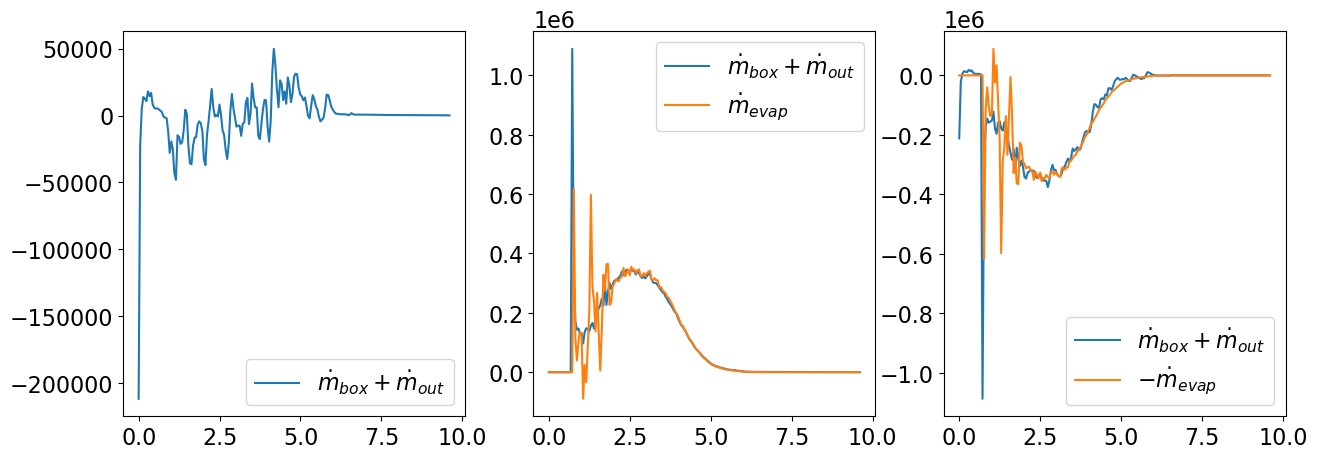

In [7]:
fig,axes= plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(time[:-1],m_box_ion+m_out_ion+m_box_neu+m_out_neu,label='$\dot{m}_{box}+\dot{m}_{out}$')
axes[0].legend()

axes[1].plot(time[:-1],m_box_ion+m_out_ion,label='$\dot{m}_{box}+\dot{m}_{out}$')
axes[1].plot(time[:-1],m_evap,label='$\dot{m}_{evap}$')
axes[1].legend()

axes[2].plot(time[:-1],m_box_neu+m_out_neu,label='$\dot{m}_{box}+\dot{m}_{out}$')
axes[2].plot(time[:-1],-m_evap,label='$-\dot{m}_{evap}$')
axes[2].legend()

### time-integrated version

In [8]:
def integrate(t,val):
    dt=t[1:]-t[:-1]
    dval=dt*val[:-1]
    result=[np.sum(dval[:k]) for k in range(len(dval))]
    return t[:-1], np.array(result)

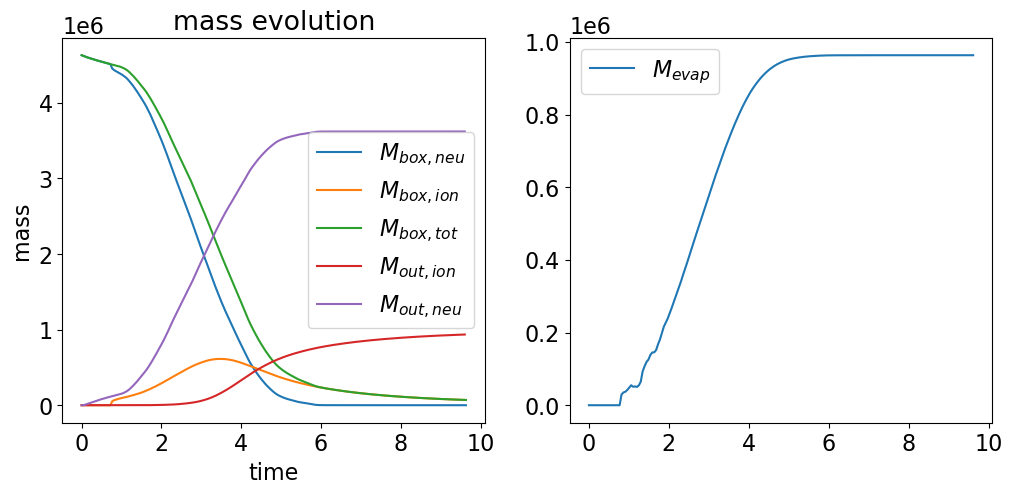

In [9]:
fig,axes= plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(time,m_neu,label='$M_{box,neu}$')
axes[0].plot(time,m_ion,label='$M_{box,ion}$')
axes[0].plot(time,m_ion+m_neu,label='$M_{box,tot}$')
M_out_ion=integrate(time,t2['Mass_ion_total'])
M_out_neu=integrate(time,t2['Mass_neu_total'])
M_evap=integrate(time,t1['Mion_evap_total'])

axes[0].plot(time[:-1],M_out_ion[1],label='$M_{out,ion}$')
axes[0].plot(time[:-1],M_out_neu[1],label='$M_{out,neu}$')

axes[0].set_xlabel('time')
axes[0].set_ylabel('mass')
axes[0].legend()
axes[0].set_title('mass evolution')

axes[1].plot(time[:-1],-M_evap[1],label='$M_{evap}$')
axes[1].legend()

### after the evolution progresses enough, there is no increase of M_evap, because ionizaiton equillibrium is achieved.
### in this model, Q49n2, shows low efficient photoionization, As shown in the left graph(a large fraction of gas exits the domain in neutral phase)

## 2) radial momentum

### $\dot{p}_{box}+\dot{p}_{out}-\dot{p}_{cent}=-F_{thm}$
### $\dot{p}_{ion.box}+\dot{p}_{ion.out}-\dot{p}_{ion.cent}=-F_{ion.thm}+\dot{p}_{evap}$
### $\dot{p}_{neu,box}+\dot{p}_{neu,out}-\dot{p}_{neu,cent}=-F_{neu,thm}-\dot{p}_{evap}$

### $F_{thm}=\int (-\nabla_{r} P) dV$
### $\dot{p}_{cent}=\int \rho (\hat{r} \times v)^2/r dV$
### $\dot{p}_{evap}=\int \dot{\rho}_{hi} v_{rad}dV$

In [14]:
region='total'
def integrate(t,val):
    dt=t[1:]-t[:-1]
    dval=dt*val[:-1]
    result=[np.sum(dval[:k]) for k in range(len(dval))]
    return t[1:], np.array(result)


t=t2['time_'+region]
dt=t[1:]-t[:-1]
p_ion=t1['radial_momentum_ion_'+region]
p_neu=t1['radial_momentum_neu_'+region]
p_box_ion=(p_ion[1:]-p_ion[:-1])/dt
p_box_neu=(p_neu[1:]-p_neu[:-1])/dt

p_out_ion=t2['radial_momentum_ion_'+region]
p_out_neu=t2['radial_momentum_neu_'+region]

centri_ion=t1['centrifugal_ion_'+region]
centri_neu=t1['centrifugal_neu_'+region]

p_evap=t1['p_evap_total']

F=t1['PdV_total']
F_ion=t1['PdV_ion_total']
F_neu=t1['PdV_neu_total']

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_51295/1085131920.py:3: SyntaxWarning: invalid escape sequence '\d'
  ,label='$\dot{m}_{box}+\dot{m}_{out}-\dot{p}_{centri}$')
/tmp/ipykernel_51295/1085131920.py:8: SyntaxWarning: invalid escape sequence '\d'
  axes[0][1].plot(time[:-1],p_box_ion+p_out_ion[:-1]-centri_ion[:-1],

Text(0.5, 1.0, 'neutral')

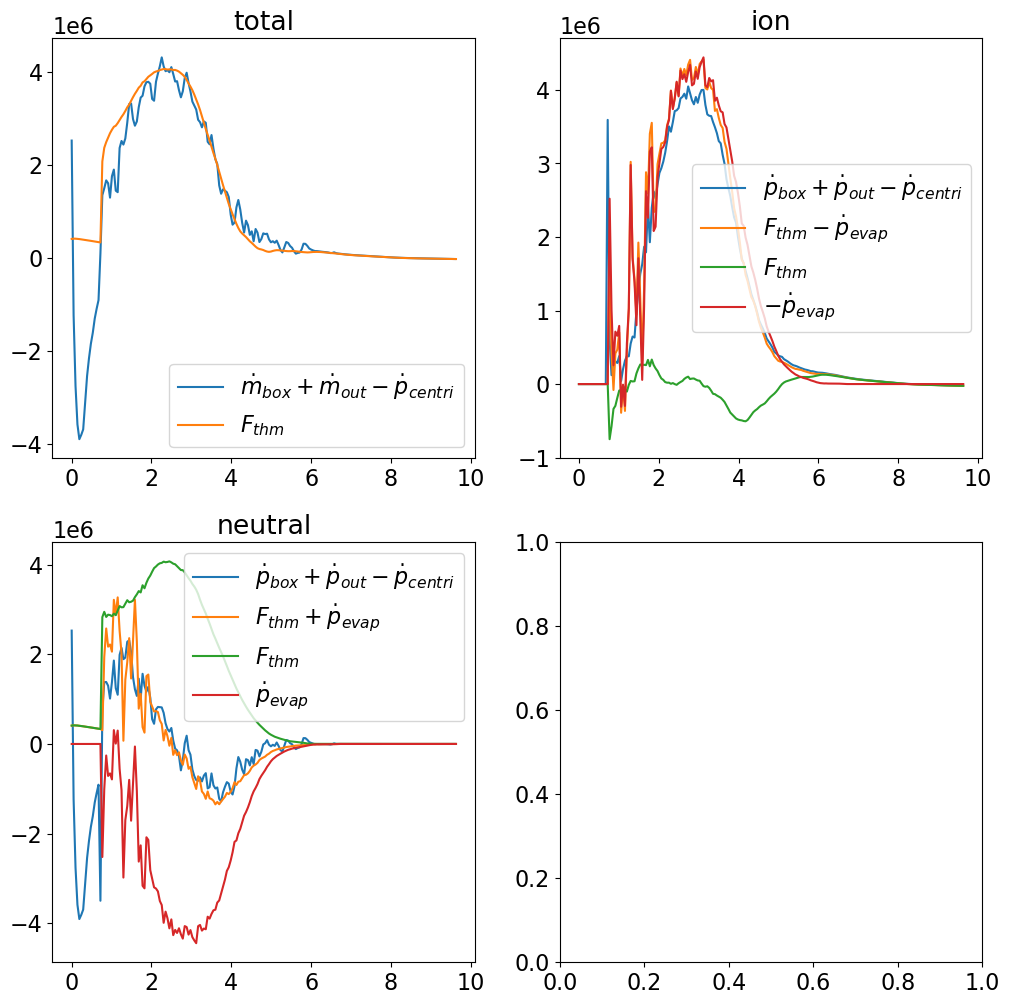

In [19]:
fig,axes= plt.subplots(2, 2, figsize=(12, 12))
axes[0][0].plot(time[:-1],p_box_ion+p_out_ion[:-1]+p_box_neu+p_out_neu[:-1]-centri_ion[:-1]-centri_neu[:-1]
             ,label='$\dot{m}_{box}+\dot{m}_{out}-\dot{p}_{centri}$')
axes[0][0].plot(time,-F,label='$F_{thm}$')
axes[0][0].legend()
axes[0][0].set_title('total')

axes[0][1].plot(time[:-1],p_box_ion+p_out_ion[:-1]-centri_ion[:-1],label='$\dot{p}_{box}+\dot{p}_{out}-\dot{p}_{centri}$')
axes[0][1].plot(time,-(F_ion+p_evap),label='$F_{thm}-\dot{p}_{evap}$')
axes[0][1].plot(time,-(F_ion),label='$F_{thm}$')
axes[0][1].plot(time,-(p_evap),label='$-\dot{p}_{evap}$')
axes[0][1].legend()
axes[0][1].set_title('ion')

axes[1][0].plot(time[:-1],p_box_neu+p_out_neu[:-1]-centri_neu[:-1],label='$\dot{p}_{box}+\dot{p}_{out}-\dot{p}_{centri}$')
axes[1][0].plot(time,-F_neu+p_evap,label='$F_{thm}+\dot{p}_{evap}$')
axes[1][0].plot(time,-F_neu,label='$F_{thm}$')
axes[1][0].plot(time,p_evap,label='$\dot{p}_{evap}$')
axes[1][0].legend()
axes[1][0].set_title('neutral')

### obviously, neutral gas is subject to stronger force by pressure gradient, but simultaneously, radial momentum of 
### neutral gas is delivered to ionized gas by photoionization.
### there is a remaining questio. why two terms are different at t<t0_src? is there another term? or just because high order of centrifugal & p_box term?
### (look below graph. I just moved centrifugal term to source part, and the error in the above graph turned out to be a low-order term)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_51295/2184174606.py:1: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(time[:-1],p_box_ion+p_out_ion[:-1]+p_box_neu+p_out_neu[:-1],label='$\dot{p}_{box}+\dot{p}_{out}$')
/tmp/ipykernel_51295/2184174606.py:2: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(time,+centri_ion+centri_neu-F,label='$\dot{p}_{cent}+F_{thm}$')


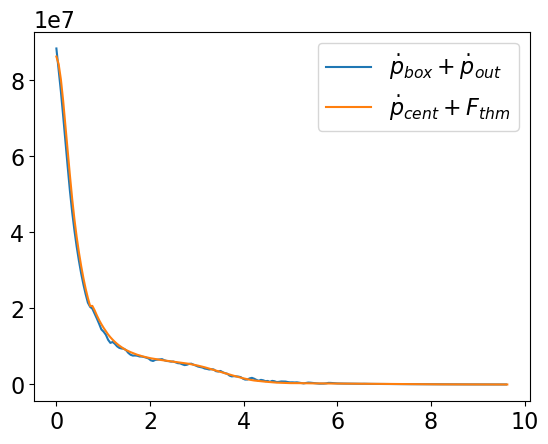

In [24]:
plt.plot(time[:-1],p_box_ion+p_out_ion[:-1]+p_box_neu+p_out_neu[:-1],label='$\dot{p}_{box}+\dot{p}_{out}$')
plt.plot(time,+centri_ion+centri_neu-F,label='$\dot{p}_{cent}+F_{thm}$')
plt.legend()
#plt.yscale('log')

### time-integrated version

In [12]:
P_out_ion=integrate(time,t2['radial_momentum_ion_total'])
P_out_neu=integrate(time,t2['radial_momentum_neu_total'])
P_evap=integrate(time,t1['p_evap_total'])
F_ion=integrate(time,t1['PdV_ion_total'])
F_neu=integrate(time,t1['PdV_neu_total'])
Centri_ion=integrate(time,t1['centrifugal_ion_total'])
Centri_neu=integrate(time,t1['centrifugal_neu_total'])

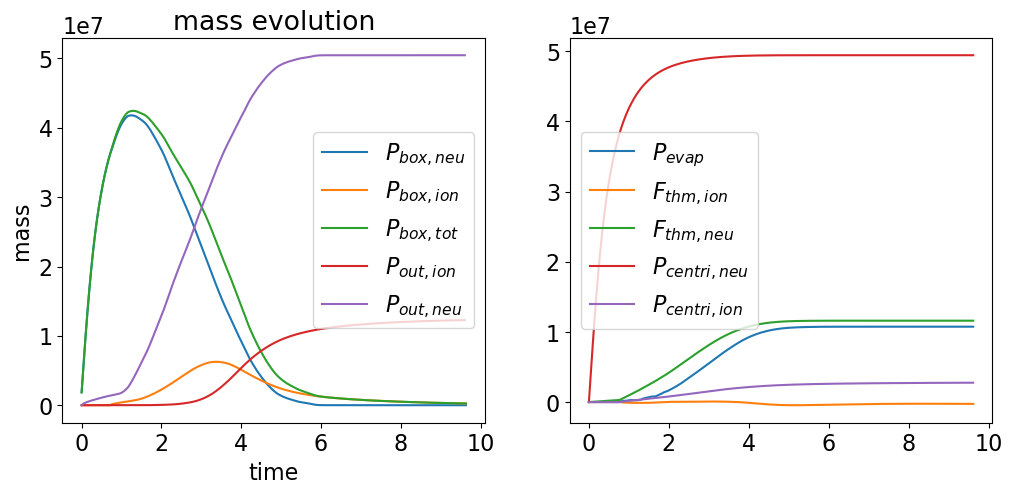

In [13]:
fig,axes= plt.subplots(1, 2, figsize=(12,5))
axes[0].plot(time,p_neu,label='$P_{box,neu}$')
axes[0].plot(time,p_ion,label='$P_{box,ion}$')
axes[0].plot(time,p_ion+p_neu,label='$P_{box,tot}$')

axes[0].plot(time[:-1],P_out_ion[1],label='$P_{out,ion}$')
axes[0].plot(time[:-1],P_out_neu[1],label='$P_{out,neu}$')

axes[0].set_xlabel('time')
axes[0].set_ylabel('mass')
axes[0].legend()
axes[0].set_title('radial momentum evolution')
axes[1].plot(time[:-1],-P_evap[1],label='$P_{evap}$')
axes[1].plot(time[:-1],-F_ion[1],label='$F_{thm,ion}$')
axes[1].plot(time[:-1],-F_neu[1],label='$F_{thm,neu}$')
axes[1].plot(time[:-1],Centri_neu[1],label='$P_{centri,neu}$')
axes[1].plot(time[:-1],Centri_ion[1],label='$P_{centri,ion}$')
axes[1].legend()

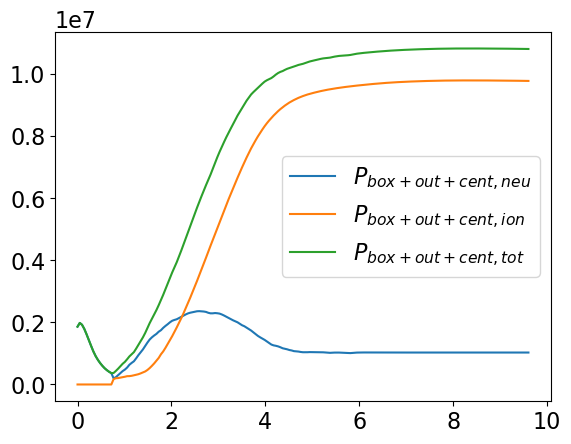

In [32]:
plt.plot(time[:-1],p_neu[:-1]+P_out_neu[1]-Centri_neu[1],label='$P_{box+out+cent,neu}$')
plt.plot(time[:-1],p_ion[:-1]+P_out_ion[1]-Centri_ion[1],label='$P_{box+out+cent,ion}$')
plt.plot(time[:-1],p_ion[:-1]+p_neu[:-1]+P_out_ion[1]+P_out_neu[1]-Centri_neu[1]-Centri_ion[1],label='$P_{box+out+cent,tot}$')
plt.legend()

### because gas loses its non-radial momentum rapidly after the source turns on, centrifugal term only dominates at the beginning of simulation and about neutral gas.
### except the effect of centrifugal term, net radial momentum gain of ion gas is bigger than neutral gas.
### thus, it was just caused by centrifugal term that P_box+P_out of neutral gas is bigger than ion gas, although it was  
### also fact that radial force from pressure gradient delivered more radial momentum to neutral gas than ionized gas.
### 
### by these two facts, someone may misunderstand that radial force dominates momentum evolution, and neutral gas get net radial momentum gain.
### In fact, the evolution of momentum is actually dominated by photoionization.